In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("../..") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
model = p2v.P2V()
d=100
w=10

2024-11-08 15:17:06 -- start loading Mag_venue_info_df
2024-11-08 15:17:06 -- finish.
2024-11-08 15:17:06 -- start loading labeled_journal_info_df
2024-11-08 15:17:06 -- finish.


## tracking PRL&JACS

Journal of the American Chemical Society  
111155417  
Physical Review Letters  
24807848  

## JACS

In [4]:
def default_value():
    return 0


def count_paper_num_for_subarea(VID, percentage: bool=False, collapse_into_others: int=20):
    dict_list = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[
                            (journal_ref_df['subarea_label'].str.contains('General'))|
                            (journal_ref_df['subarea_label'].str.contains('miscellaneous'))|
                            (journal_ref_df['subarea_label']=='Multidisciplinary')].index, 
                            inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['subarea_label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)

    if collapse_into_others != 0:
        count_df.reset_index(inplace=True)
        count_df = count_df.sort_values("sum", ascending=False)
        count_df_up = count_df.iloc[:collapse_into_others]
        count_df_full = pd.concat([count_df_up, pd.DataFrame({'index': 'others', 
                                                            '1970s': count_df['1970s'].iloc[10:].sum(), 
                                                            '1980s': count_df['1980s'].iloc[10:].sum(), 
                                                            '1990s': count_df['1990s'].iloc[10:].sum(), 
                                                            '2000s': count_df['2000s'].iloc[10:].sum(), 
                                                            '2010s': count_df['2010s'].iloc[10:].sum(), 
                                                            'sum': count_df['sum'].iloc[7:].sum()}, 
                                                            index=[0])], 
                                ignore_index=True)
        count_df_full.set_index('index', inplace=True)
    else:
        count_df_full = count_df


    if percentage:
        count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
        count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
        count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
        count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
        count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100

    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_subarea_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['subarea_label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            
            single_decade_data[subarea] = np.mean((single_subarea_cs))
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

def cal_subarea_all_cs(target_VID: int):
    start_year_list = model.start_year_list[-5:]
    end_year_list = model.end_year_list[-5:]

    cs_df = pd.DataFrame(columns=['VID', 'similarity', 'decade', 'subarea'])
    for start_year, end_year in zip(start_year_list, end_year_list):
        model.load_wv(start_year, end_year, 100, 10)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in VID_labeled['VID']])

        label_list = VID_labeled['subarea_label']
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(VID_labeled['subarea_label'])) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), 
                                                  labeled_vector_list[single_subarea_idx_list])
            for idx, cs_value in enumerate(single_subarea_cs[0]):
                new_row = {
                    'VID': VID_labeled['VID'][single_subarea_idx_list[idx]],
                    'similarity': cs_value,
                    'decade': f"{start_year}s",
                    'subarea': subarea
                }
                cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)
    return cs_df

def cal_jnl_cs(center_vname: str, venue_name_list: list):
    center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname].index[0]
    jnl_cs_df = pd.DataFrame(columns=venue_name_list)
    
    for i, start_year in enumerate(start_year_list):
        end_year = end_year_list[i]
        wv = model.load_wv(start_year, end_year, d, w)
        
        for venue_name in venue_name_list:
            VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
            try:
                sim = wv.similarity(center_VID, VID)
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = sim
            except KeyError:
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = np.nan
    return jnl_cs_df

In [5]:
count_df = count_paper_num_for_subarea(111155417, collapse_into_others=20)

2024-11-08 15:17:13 -- start searching in 1970 to 1979
2024-11-08 15:17:13 -- start loading 'paper_df'...
2024-11-08 15:17:13 -- finish.
2024-11-08 15:17:13 -- start loading 'ref_df'...
2024-11-08 15:17:13 -- finish.
2024-11-08 15:17:13 -- start loading VID_labeled...
2024-11-08 15:17:13 -- finish.
2024-11-08 15:17:14 -- start searching in 1980 to 1989
2024-11-08 15:17:14 -- start loading 'paper_df'...
2024-11-08 15:17:14 -- finish.
2024-11-08 15:17:14 -- start loading 'ref_df'...
2024-11-08 15:17:14 -- finish.
2024-11-08 15:17:14 -- start loading VID_labeled...
2024-11-08 15:17:14 -- finish.
2024-11-08 15:17:15 -- start searching in 1990 to 1999
2024-11-08 15:17:15 -- start loading 'paper_df'...
2024-11-08 15:17:15 -- finish.
2024-11-08 15:17:15 -- start loading 'ref_df'...
2024-11-08 15:17:16 -- finish.
2024-11-08 15:17:16 -- start loading VID_labeled...
2024-11-08 15:17:16 -- finish.
2024-11-08 15:17:19 -- start searching in 2000 to 2009
2024-11-08 15:17:19 -- start loading 'paper_d

In [6]:
count_df

decade,Organic Chemistry,Physical and Theoretical Chemistry,Inorganic Chemistry,Biochemistry,Polymers and Plastics,Condensed Matter Physics,Molecular Biology,Catalysis,Cell Biology,Analytical Chemistry,"Renewable Energy, Sustainability and the Environment",Drug Discovery,"Electronic, Optical and Magnetic Materials",Biophysics,Genetics,Pharmaceutical Science,Electrochemistry,Biotechnology,Spectroscopy,"Atomic and Molecular Physics, and Optics",others
1970s,4.000000,4.000000,4.500000,1.000000,NaN,2.500000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
1980s,6.500000,4.000000,6.500000,2.000000,1.000000,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,3.000000
1990s,1940.350000,1749.909524,1418.716667,1226.576190,236.742857,254.192857,241.350000,52.783333,92.600000,113.392857,0.333333,89.883333,4.650000,32.583333,56.683333,10.866667,28.400000,17.083333,85.116667,16.166667,800.385714
2000s,5114.372619,5022.121429,3281.959524,2772.983333,1032.978571,1280.541667,808.157143,330.476190,535.771429,450.305952,24.642857,375.844048,72.866667,429.260714,225.495238,203.410714,140.286905,297.132143,150.884524,47.409524,3182.332143
2010s,7254.749242,5772.702020,3080.243290,2136.507215,1498.334560,920.452814,784.119481,1098.454762,487.732576,544.689286,984.709524,268.297619,537.645635,123.774603,245.381349,309.114286,247.045635,71.330592,65.783333,194.969048,4605.014755


In [7]:
cs_df = cal_subarea_avg_cs(111155417)

2024-11-08 15:18:10 -- start loading word vectors...
2024-11-08 15:18:10 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 15:18:10 -- start loading VID_labeled...
2024-11-08 15:18:10 -- finish.
2024-11-08 15:18:10 -- start loading word vectors...
2024-11-08 15:18:10 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 15:18:10 -- start loading VID_labeled...
2024-11-08 15:18:10 -- finish.
2024-11-08 15:18:10 -- start loading word vectors...
2024-11-08 15:18:10 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 15:18:10 -- start loading VID_labeled...
2024-11-08 15:18:10 -- finish.
2024-11-08 15:18:10 -- start loading word vectors...
2024-11-08 15:18:10 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 15:18:10 -- start loading VID_labeled...
2024-11-08 15:18:10 -- finish.
2024-11-08 15:18:11 -- start loading word vectors...
2024-11-08 15:18:11 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 15:18:11 -- start l

In [8]:
cs_df

decade,Catalysis,Inorganic Chemistry,Organic Chemistry,Physical and Theoretical Chemistry,General Chemistry,Molecular Medicine,Spectroscopy,Materials Chemistry,Polymers and Plastics,Electrochemistry,"Electronic, Optical and Magnetic Materials",Biochemistry,Colloid and Surface Chemistry,Analytical Chemistry,Drug Discovery,Condensed Matter Physics,General Materials Science,"Surfaces, Coatings and Films",General Chemical Engineering,Fuel Technology,Geochemistry and Petrology,Biomaterials,Molecular Biology,Environmental Chemistry,"Atomic and Molecular Physics, and Optics",Applied Microbiology and Biotechnology,General Physics and Astronomy,Ceramics and Composites,Structural Biology,Chiropractics,Physics and Astronomy (miscellaneous),Metals and Alloys,Filtration and Separation,Nuclear and High Energy Physics,Biophysics,Surfaces and Interfaces,Pharmaceutical Science,Microbiology,Radiation,Energy Engineering and Power Technology,Space and Planetary Science,Cancer Research,"General Biochemistry, Genetics and Molecular Biology",Instrumentation,Pharmacology,"Renewable Energy, Sustainability and the Environment",Biotechnology,Conservation,Mathematical Physics,Mechanics of Materials,Statistical and Nonlinear Physics,Geology,Plant Science,Cellular and Molecular Neuroscience,Astronomy and Astrophysics,Cell Biology,Bioengineering,Soil Science,Environmental Engineering,Geometry and Topology,Algebra and Number Theory,Discrete Mathematics and Combinatorics,Fluid Flow and Transfer Processes,Oceanography,Insect Science,General Engineering,Food Science,Pollution,Horticulture,Control and Optimization,Nuclear Energy and Engineering,Paleontology,Virology,Toxicology,"Health, Toxicology and Mutagenesis",Multidisciplinary,Geophysics,General Energy,Electrical and Electronic Engineering,Logic,General Mathematics,Global and Planetary Change,General Earth and Planetary Sciences,Analysis,Mechanical Engineering,Computational Theory and Mathematics,Waste Management and Disposal,Forestry,Immunology,Oncology,Aquatic Science,Microbiology (medical),Endocrinology,Atmospheric Science,Agronomy and Crop Science,Biological Psychiatry,Finance,Genetics,Clinical Biochemistry,Agricultural and Biological Sciences (miscellaneous),Automotive Engineering,Hematology,Earth and Planetary Sciences (miscellaneous),General Neuroscience,Aerospace Engineering,Process Chemistry and Technology,Neurology,Applied Mathematics,Mathematics (miscellaneous),General Agricultural and Biological Sciences,General Computer Science,"Ecology, Evolution, Behavior and Systematics",Computational Mathematics,General Environmental Science,Oral Surgery,Developmental Biology,Theoretical Computer Science,Biochemistry (medical),Literature and Literary Theory,Archeology,Geotechnical Engineering and Engineering Geology,Water Science and Technology,Language and Linguistics,Pharmacology (medical),Archeology (arts and humanities),Periodontics,"General Economics, Econometrics and Finance",Computer Networks and Communications,Classics,Developmental Neuroscience,Linguistics and Language,History and Philosophy of Science,Dermatology,History,Histology,Economics and Econometrics,Ocean Engineering,Reproductive Medicine,Software,Earth-Surface Processes,Physiology,Museology,Infectious Diseases,Computer Graphics and Computer-Aided Design,Signal Processing,Parasitology,Rheumatology,Religious Studies,Library and Information Sciences,Chemical Engineering (miscellaneous),"Economics, Econometrics and Finance (miscellaneous)",General Dentistry,Ecology,General Arts and Humanities,Optometry,Political Science and International Relations,Control and Systems Engineering,Aging,Hepatology,Accounting,Cultural Studies,Animal Science and Zoology,Cardiology and Cardiovascular Medicine,Ophthalmology,Visual Arts and Performing Arts,Education,Music,Law,Computers in Earth Sciences,Public Administration,Arts and Humanities (miscellaneous),Numerical Analysis,Industrial and Manufacturing Engineering,"Business, Management and Accounting (miscellane

In [9]:
all_cs_df = cal_subarea_all_cs(111155417)

2024-11-08 15:18:32 -- start loading word vectors...
2024-11-08 15:18:32 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 15:18:32 -- start loading VID_labeled...
2024-11-08 15:18:32 -- finish.


C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_35424\1514052452.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)


2024-11-08 15:18:34 -- start loading word vectors...
2024-11-08 15:18:34 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 15:18:34 -- start loading VID_labeled...
2024-11-08 15:18:34 -- finish.
2024-11-08 15:18:36 -- start loading word vectors...
2024-11-08 15:18:36 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 15:18:36 -- start loading VID_labeled...
2024-11-08 15:18:36 -- finish.
2024-11-08 15:18:41 -- start loading word vectors...
2024-11-08 15:18:41 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 15:18:41 -- start loading VID_labeled...
2024-11-08 15:18:41 -- finish.
2024-11-08 15:18:51 -- start loading word vectors...
2024-11-08 15:18:51 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 15:18:51 -- start loading VID_labeled...
2024-11-08 15:18:51 -- finish.


In [10]:
disciplines = ['Organic Chemistry',
               'Physical and Theoretical Chemistry',
               'Inorganic Chemistry',
               'Biochemistry',
               'Polymers and Plastics',
               'Condensed Matter Physics',
               'Molecular Biology',
               'Catalysis',
               'Cell Biology',
               'Analytical Chemistry',
               'Renewable Energy, Sustainability and the Environment',
               'Drug Discovery',
               'Electronic, Optical and Magnetic Materials',
               'Biophysics',
               'Genetics',
               'Pharmaceutical Science',
               'Electrochemistry',
               'Biotechnology',
               'Spectroscopy',
               'Atomic and Molecular Physics, and Optics',]

Pearson correlation coefficient: 0.534
P-value: 1.075e-08


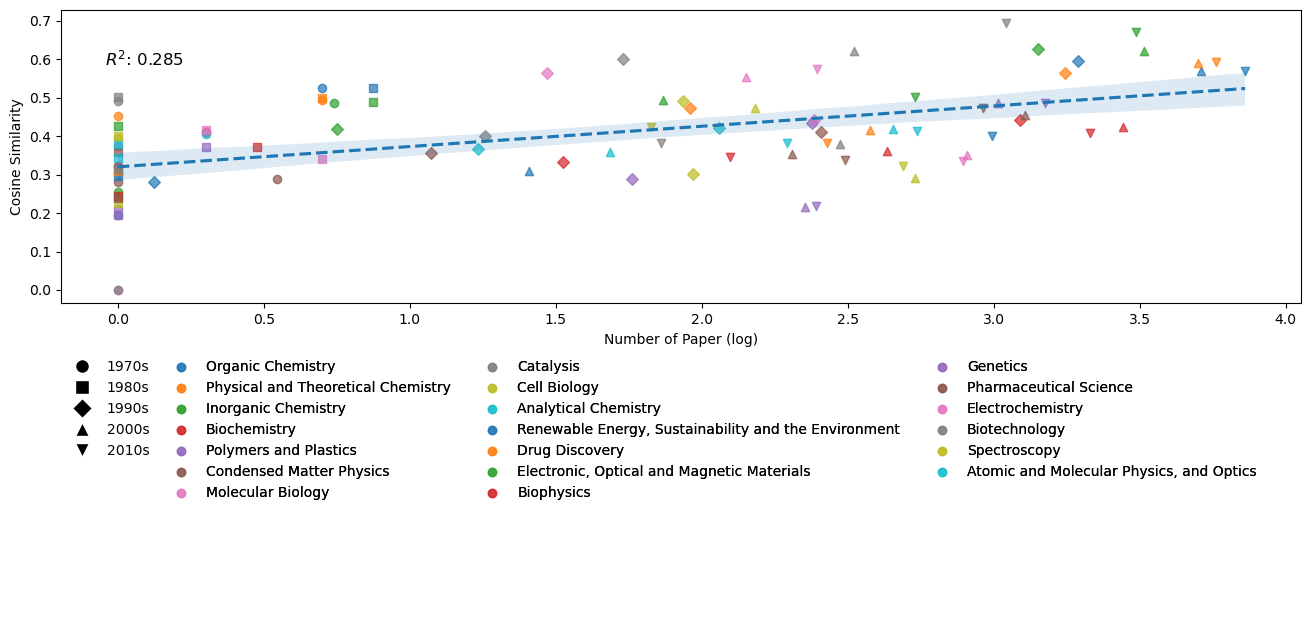

In [31]:
from scipy.stats import pearsonr

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(2,1,1)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
# discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=disc, markersize=10) for disc in disciplines]
discipline_handles, labels = ax.get_legend_handles_labels()

legend_ax = fig.add_subplot(2,1,2)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(-0.005, 0.95), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                                     loc="upper left", bbox_to_anchor=(0.075, 0.95), ncol=3, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')

plt.subplots_adjust(wspace=0.12, hspace=0.1)
plt.show()

In [32]:
fig.savefig('JACS_correlation.pdf', 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

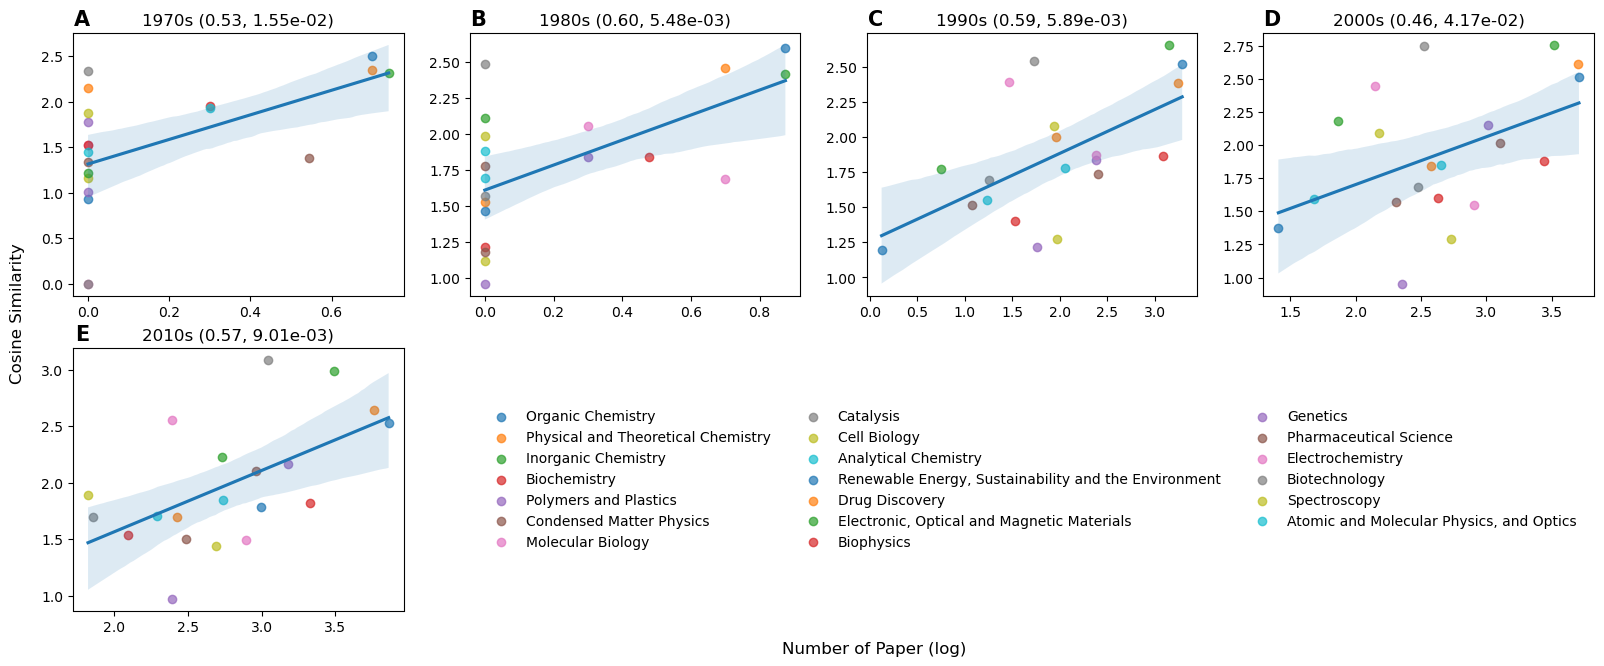

In [15]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'PNAS'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-2])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

## Archive (JACS)

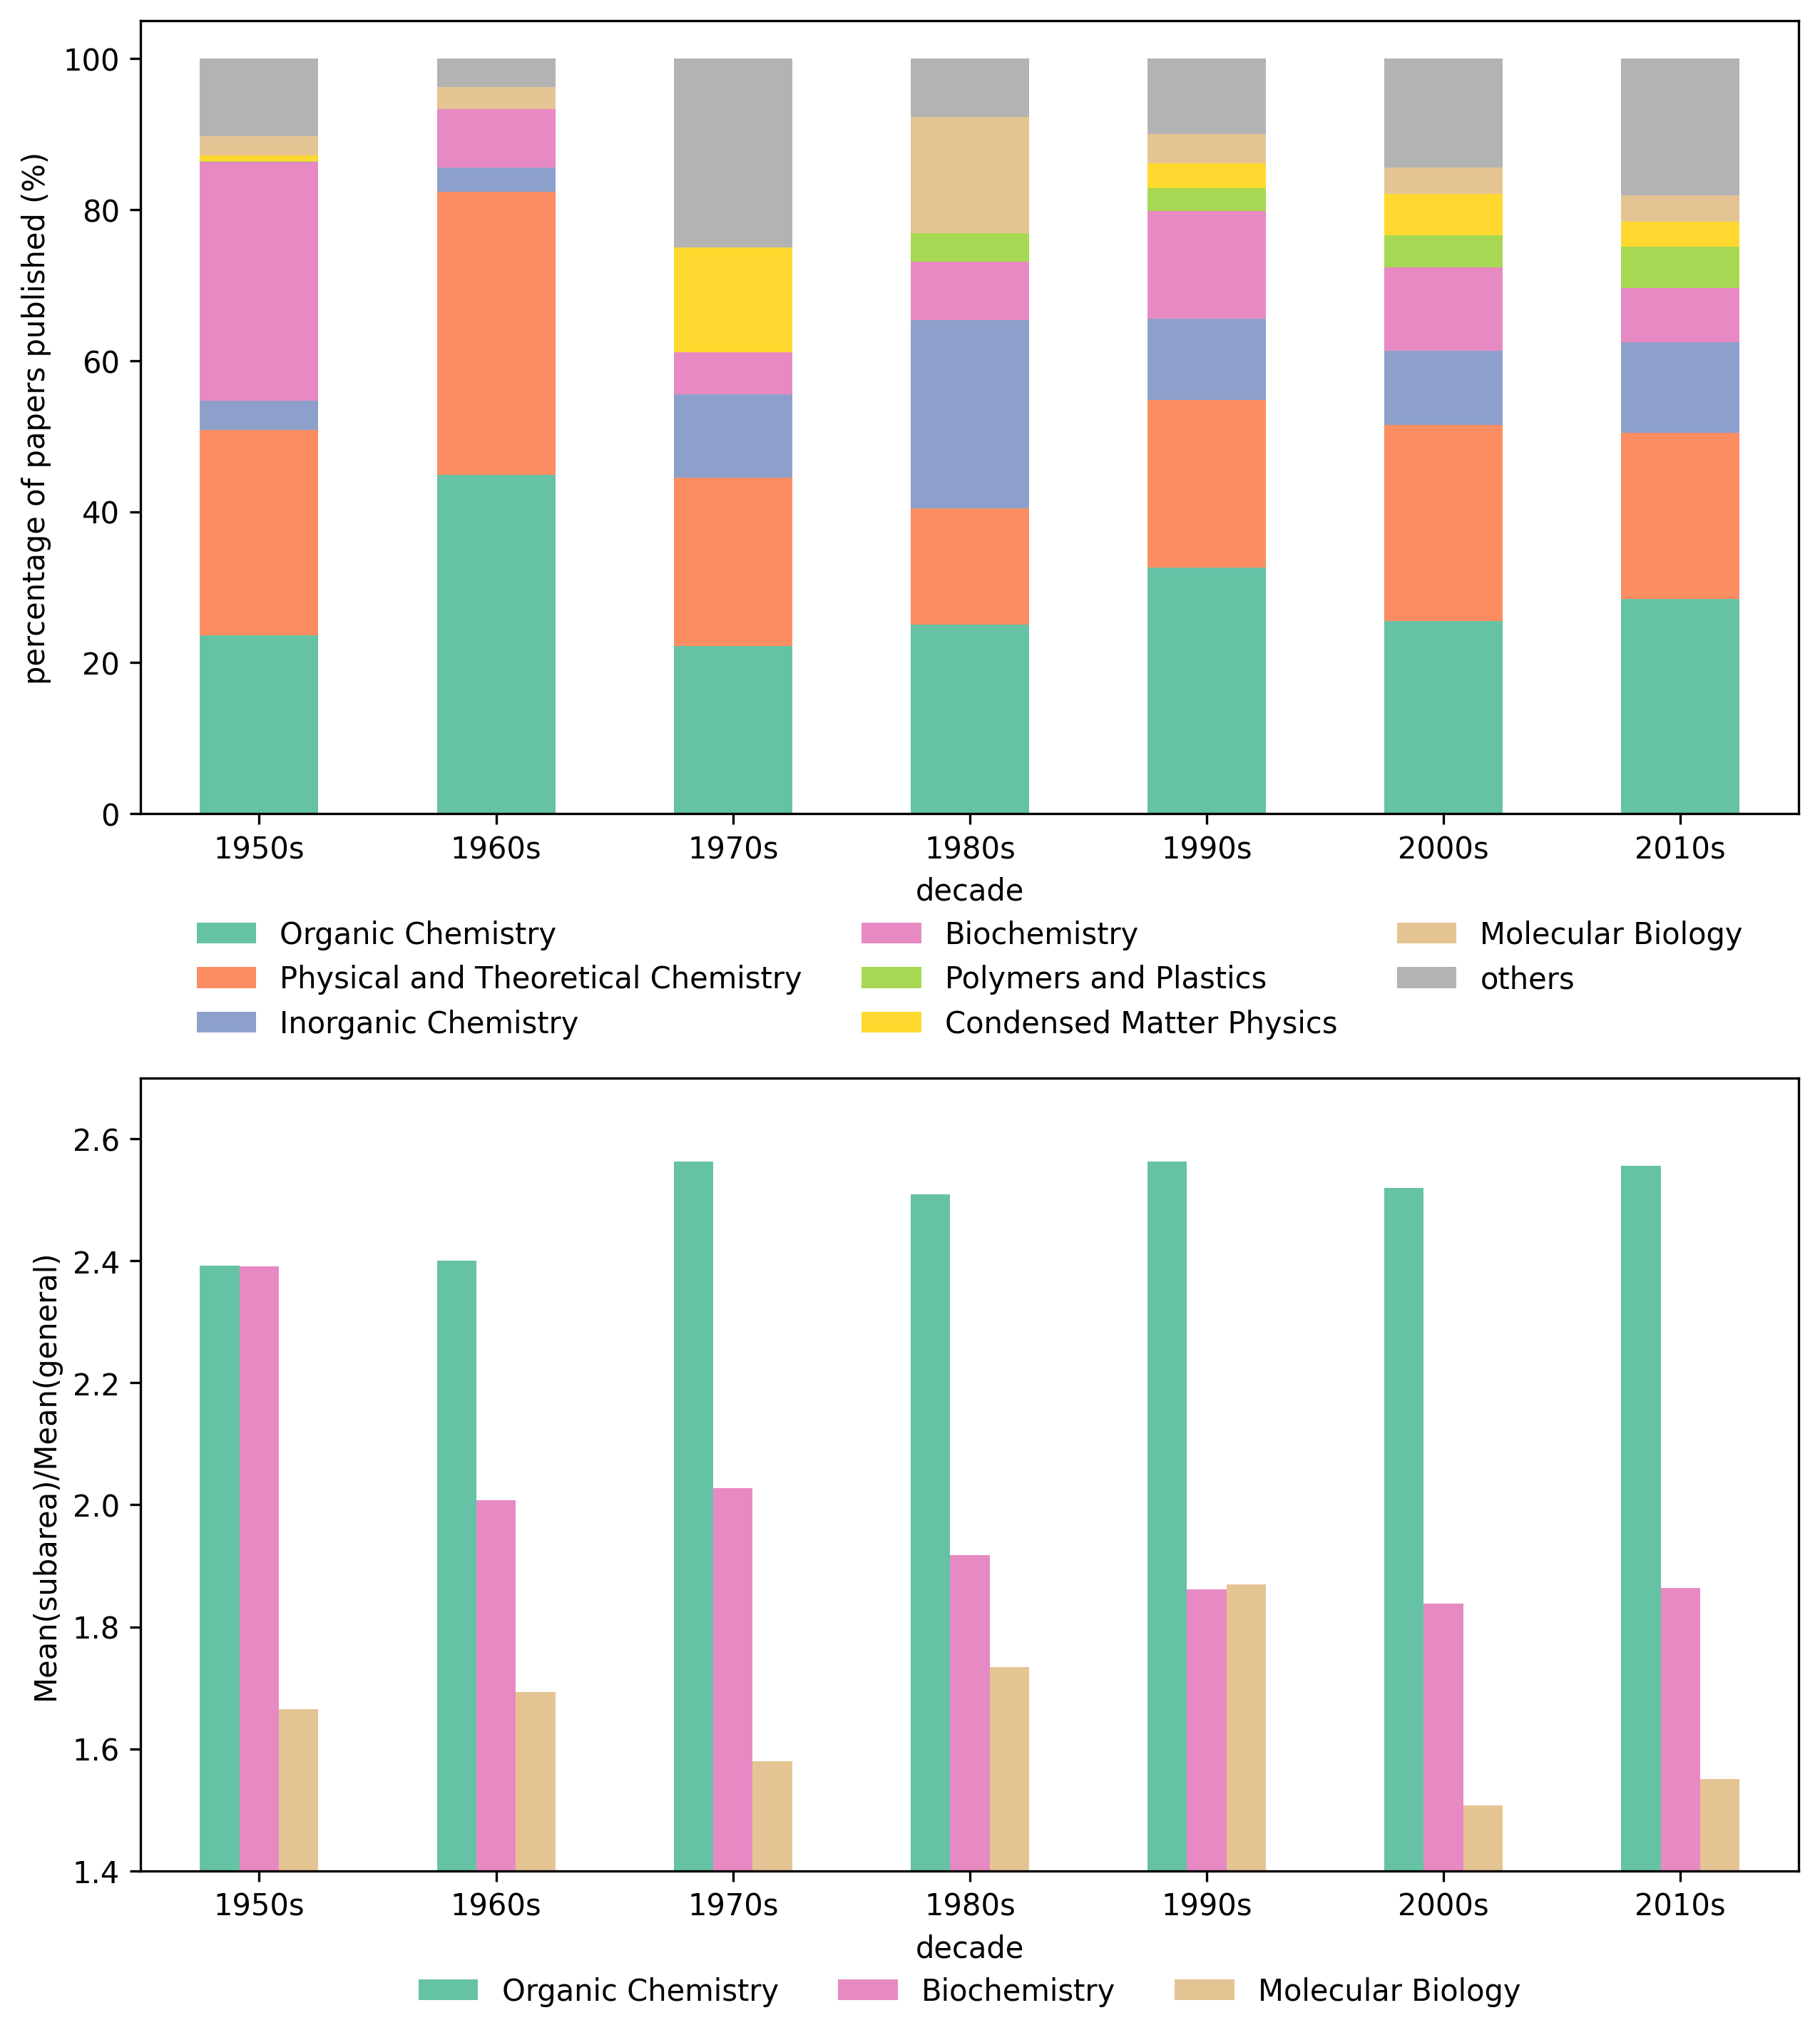

In [251]:
color_dict = {'Organic Chemistry': '#66c2a5',
              'Physical and Theoretical Chemistry': '#fc8d62',
              'Inorganic Chemistry': '#8da0cb',	
              'Biochemistry': '#e78ac3',
              'Polymers and Plastics': '#a6d854',
              'Condensed Matter Physics': '#ffd92f',
              'Molecular Biology': '#e5c494',
              'others': '#b3b3b3'}

fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Organic Chemistry',
               'Biochemistry', 
               'Molecular Biology']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.4, 2.7)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [252]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/JACS.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

## PRL

In [33]:
count_df = count_paper_num_for_subarea(24807848, collapse_into_others=20)

2024-11-08 16:18:49 -- start searching in 1970 to 1979
2024-11-08 16:18:49 -- start loading 'paper_df'...
2024-11-08 16:18:49 -- finish.
2024-11-08 16:18:49 -- start loading 'ref_df'...
2024-11-08 16:18:49 -- finish.
2024-11-08 16:18:49 -- start loading VID_labeled...
2024-11-08 16:18:49 -- finish.
2024-11-08 16:18:50 -- start searching in 1980 to 1989
2024-11-08 16:18:50 -- start loading 'paper_df'...
2024-11-08 16:18:50 -- finish.
2024-11-08 16:18:50 -- start loading 'ref_df'...
2024-11-08 16:18:50 -- finish.
2024-11-08 16:18:50 -- start loading VID_labeled...
2024-11-08 16:18:50 -- finish.
2024-11-08 16:18:52 -- start searching in 1990 to 1999
2024-11-08 16:18:52 -- start loading 'paper_df'...
2024-11-08 16:18:52 -- finish.
2024-11-08 16:18:52 -- start loading 'ref_df'...
2024-11-08 16:18:52 -- finish.
2024-11-08 16:18:52 -- start loading VID_labeled...
2024-11-08 16:18:52 -- finish.
2024-11-08 16:18:55 -- start searching in 2000 to 2009
2024-11-08 16:18:55 -- start loading 'paper_d

In [34]:
count_df

decade,Condensed Matter Physics,"Atomic and Molecular Physics, and Optics",Nuclear and High Energy Physics,Statistical and Nonlinear Physics,Physical and Theoretical Chemistry,Astronomy and Astrophysics,Mechanical Engineering,Mathematical Physics,Biophysics,Applied Mathematics,Polymers and Plastics,Instrumentation,Mechanics of Materials,Atmospheric Science,Molecular Biology,Metals and Alloys,Cell Biology,Electrical and Electronic Engineering,Genetics,"Electronic, Optical and Magnetic Materials",others
1970s,167.666667,51.583333,64.000000,2.000000,24.416667,NaN,1.000000,7.500000,1.500000,NaN,0.250000,2.500000,NaN,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,22.333333
1980s,217.083333,95.750000,135.333333,4.250000,42.666667,2.500000,12.250000,13.333333,2.000000,3.000000,1.500000,2.833333,2.500,NaN,1.000000,NaN,NaN,3.500000,NaN,2.000000,28.833333
1990s,346.333333,200.916667,317.166667,136.500000,77.500000,14.583333,46.416667,35.416667,22.166667,34.166667,8.583333,4.666667,1.250,2.000000,6.416667,1.000000,6.666667,5.833333,3.000000,4.000000,125.833333
2000s,3451.709524,1759.292857,934.833333,992.042857,587.342857,195.500000,117.616667,168.916667,138.069048,102.350000,91.316667,67.185714,41.700,60.166667,39.952381,33.426190,48.259524,44.166667,36.183333,10.833333,891.326190
2010s,5155.502381,3708.842857,2638.400000,1096.752381,675.475000,458.283333,258.526190,149.525000,70.119048,85.366667,89.809524,107.766667,71.725,48.983333,58.594048,70.458333,48.451190,36.483333,31.976190,49.341667,1025.207143


In [35]:
cs_df = cal_subarea_avg_cs(24807848)

2024-11-08 16:19:27 -- start loading word vectors...
2024-11-08 16:19:27 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 16:19:27 -- start loading VID_labeled...
2024-11-08 16:19:27 -- finish.
2024-11-08 16:19:27 -- start loading word vectors...
2024-11-08 16:19:27 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 16:19:27 -- start loading VID_labeled...
2024-11-08 16:19:27 -- finish.
2024-11-08 16:19:27 -- start loading word vectors...
2024-11-08 16:19:27 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 16:19:27 -- start loading VID_labeled...
2024-11-08 16:19:27 -- finish.
2024-11-08 16:19:28 -- start loading word vectors...
2024-11-08 16:19:28 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 16:19:28 -- start loading VID_labeled...
2024-11-08 16:19:28 -- finish.
2024-11-08 16:19:28 -- start loading word vectors...
2024-11-08 16:19:28 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 16:19:28 -- start l

In [36]:
cs_df

decade,Statistical and Nonlinear Physics,General Physics and Astronomy,Mathematical Physics,Physics and Astronomy (miscellaneous),Nuclear and High Energy Physics,Condensed Matter Physics,"Atomic and Molecular Physics, and Optics","Electronic, Optical and Magnetic Materials",Astronomy and Astrophysics,Physical and Theoretical Chemistry,Space and Planetary Science,General Mathematics,Geometry and Topology,Analysis,General Materials Science,Mechanics of Materials,Nuclear Energy and Engineering,Ceramics and Composites,Metals and Alloys,Algebra and Number Theory,Mathematics (miscellaneous),Applied Mathematics,Materials Chemistry,Geophysics,Electrical and Electronic Engineering,Computational Mathematics,Instrumentation,Control and Optimization,Fluid Flow and Transfer Processes,Catalysis,"Surfaces, Coatings and Films",Discrete Mathematics and Combinatorics,Mechanical Engineering,General Engineering,Geochemistry and Petrology,Inorganic Chemistry,Signal Processing,Aerospace Engineering,Polymers and Plastics,Computational Theory and Mathematics,Theoretical Computer Science,Colloid and Surface Chemistry,Logic,General Chemistry,Atmospheric Science,"Renewable Energy, Sustainability and the Environment",Chiropractics,Computer Networks and Communications,Earth and Planetary Sciences (miscellaneous),Energy Engineering and Power Technology,Electrochemistry,General Chemical Engineering,General Computer Science,Spectroscopy,Numerical Analysis,Geology,Control and Systems Engineering,Fuel Technology,Acoustics and Ultrasonics,Finance,Software,Ocean Engineering,Computer Graphics and Computer-Aided Design,Philosophy,Oceanography,General Earth and Planetary Sciences,Surfaces and Interfaces,Geotechnical Engineering and Engineering Geology,Artificial Intelligence,History and Philosophy of Science,Biophysics,Civil and Structural Engineering,Earth-Surface Processes,Language and Linguistics,Literature and Literary Theory,Computer Science Applications,Radiation,General Energy,Hardware and Architecture,Music,Information Systems,Industrial and Manufacturing Engineering,Religious Studies,Linguistics and Language,General Arts and Humanities,Automotive Engineering,Filtration and Separation,Soil Science,History,Visual Arts and Performing Arts,Psychology (miscellaneous),Cultural Studies,Computers in Earth Sciences,Water Science and Technology,Archeology (arts and humanities),Management Science and Operations Research,"General Economics, Econometrics and Finance",Archeology,Statistics and Probability,Accounting,"Economics, Econometrics and Finance (miscellaneous)",Economics and Econometrics,Political Science and International Relations,Modeling and Simulation,Paleontology,Classics,Structural Biology,Environmental Chemistry,"Business, Management and Accounting (miscellaneous)",Organic Chemistry,Ecological Modeling,Conservation,Library and Information Sciences,"Safety, Risk, Reliability and Quality",Sociology and Political Science,Multidisciplinary,Strategy and Management,Arts and Humanities (miscellaneous),Education,Analytical Chemistry,Experimental and Cognitive Psychology,Communication,Global and Planetary Change,Cognitive Neuroscience,Agricultural and Biological Sciences (miscellaneous),Organizational Behavior and Human Resource Management,Environmental Engineering,"Statistics, Probability and Uncertainty",Transportation,Business and International Management,General Social Sciences,Industrial Relations,Public Administration,"General Business, Management and Accounting",Ecology,Nature and Landscape Conservation,Process Chemistry and Technology,Social Sciences (miscellaneous),Gender Studies,Computer Vision and Pattern Recognition,Neuroscience (miscellaneous),Sensory Systems,"Geography, Planning and Development",Media Technology,Insect Science,Management of Technology and Innovation,Horticulture,Social Psychology,Building and Construction,Molecular Biology,Law,Clinical Psychology,"Ecology, Evolution, Behavior and Systematics",Forestry,Architecture,Oral Surgery,Appli

In [37]:
all_cs_df = cal_subarea_all_cs(24807848)

2024-11-08 16:19:39 -- start loading word vectors...
2024-11-08 16:19:39 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 16:19:39 -- start loading VID_labeled...
2024-11-08 16:19:39 -- finish.


C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_35424\1514052452.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)


2024-11-08 16:19:40 -- start loading word vectors...
2024-11-08 16:19:40 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 16:19:40 -- start loading VID_labeled...
2024-11-08 16:19:40 -- finish.
2024-11-08 16:19:43 -- start loading word vectors...
2024-11-08 16:19:43 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 16:19:43 -- start loading VID_labeled...
2024-11-08 16:19:43 -- finish.
2024-11-08 16:19:49 -- start loading word vectors...
2024-11-08 16:19:49 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 16:19:49 -- start loading VID_labeled...
2024-11-08 16:19:49 -- finish.
2024-11-08 16:20:02 -- start loading word vectors...
2024-11-08 16:20:02 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 16:20:02 -- start loading VID_labeled...
2024-11-08 16:20:02 -- finish.


In [38]:
disciplines = ['Condensed Matter Physics',
 'Atomic and Molecular Physics, and Optics',
 'Nuclear and High Energy Physics',
 'Statistical and Nonlinear Physics',
 'Physical and Theoretical Chemistry',
 'Astronomy and Astrophysics',
 'Mechanical Engineering',
 'Mathematical Physics',
 'Biophysics',
 'Applied Mathematics',
 'Polymers and Plastics',
 'Instrumentation',
 'Mechanics of Materials',
 'Atmospheric Science',
 'Molecular Biology',
 'Metals and Alloys',
 'Cell Biology',
 'Electrical and Electronic Engineering',
 'Genetics',
 'Electronic, Optical and Magnetic Materials',]

Pearson correlation coefficient: 0.454
P-value: 2.087e-06


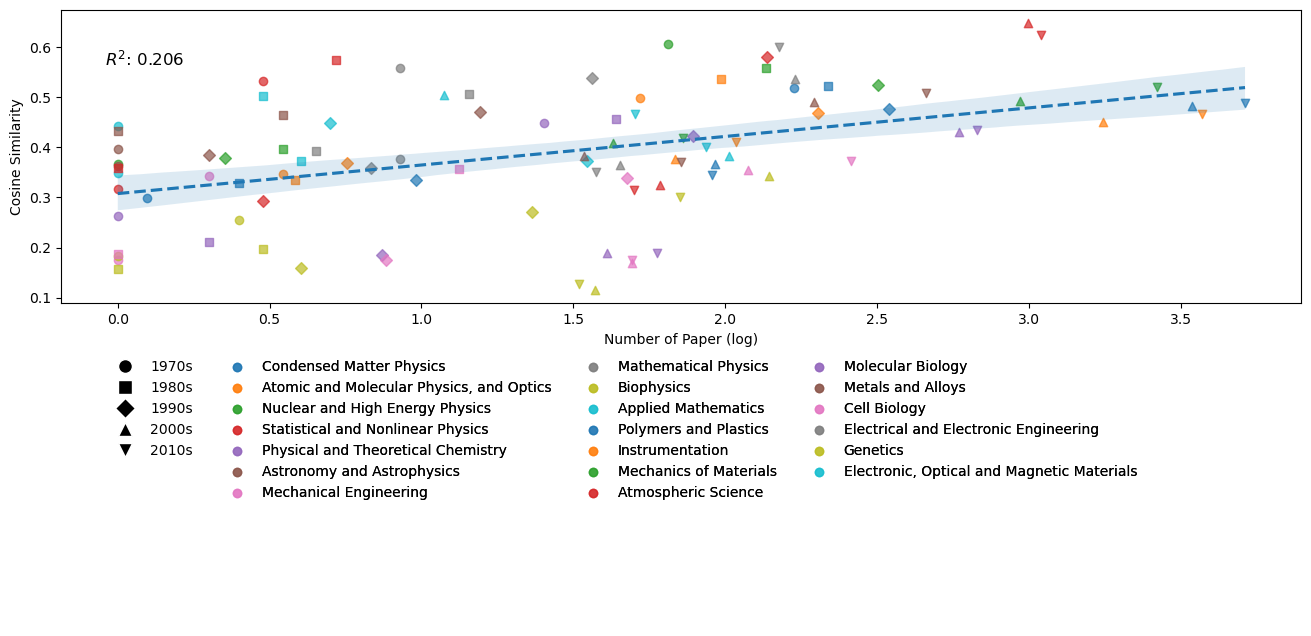

In [49]:
from scipy.stats import pearsonr

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(2,1,1)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
# discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=disc, markersize=10) for disc in disciplines]
discipline_handles, labels = ax.get_legend_handles_labels()

legend_ax = fig.add_subplot(2,1,2)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(0.03, 0.95), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                                     loc="upper left", bbox_to_anchor=(0.12, 0.95), ncol=3, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')

plt.subplots_adjust(wspace=0.12, hspace=0.1)
plt.show()

In [50]:
fig.savefig('PRL_correlation.pdf', 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

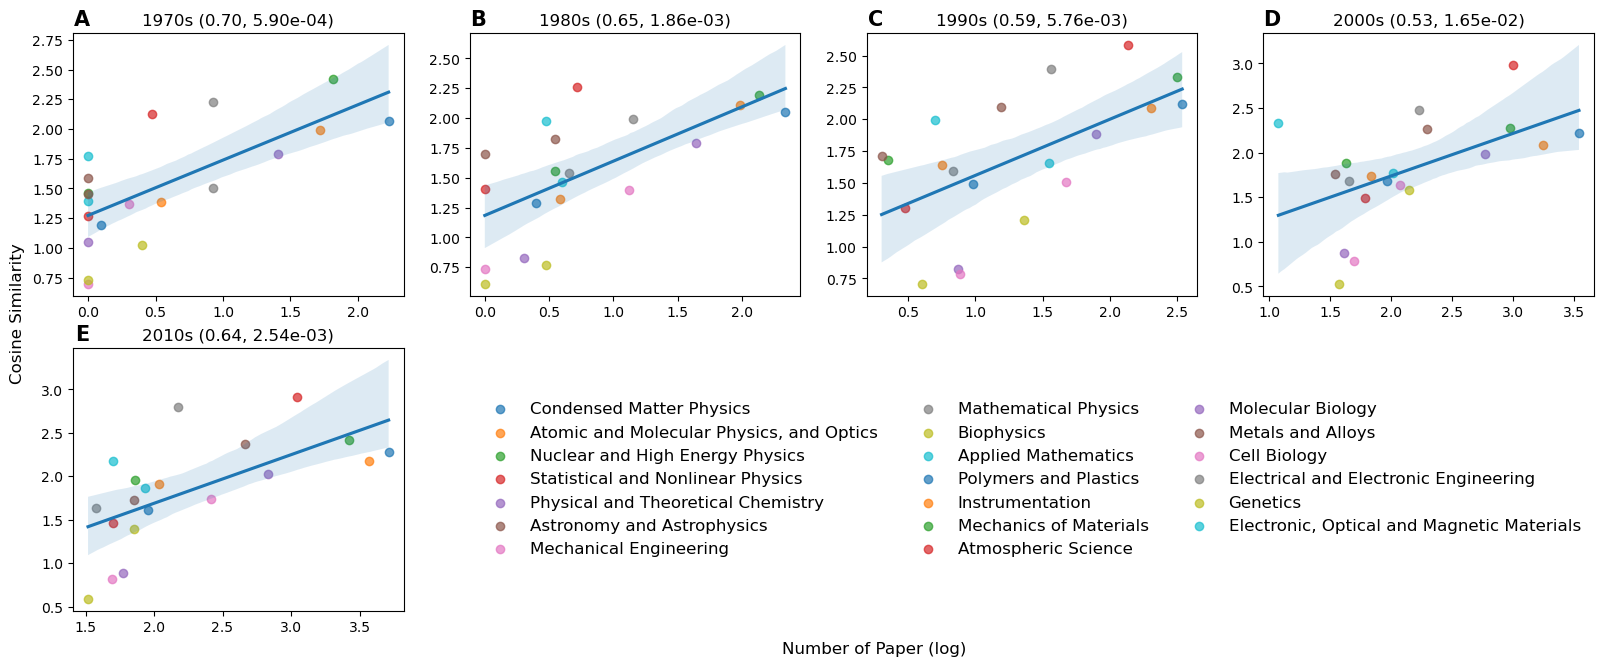

In [28]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 2x4 的 GridSpec 布局（2 行 4 列）
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(2, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFG")
center_venue = 'PNAS'

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第8幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-2])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=3, prop={'size': 12}, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.075, wspace=0.1, hspace=0.2)

plt.show()

## Archive (PRL)

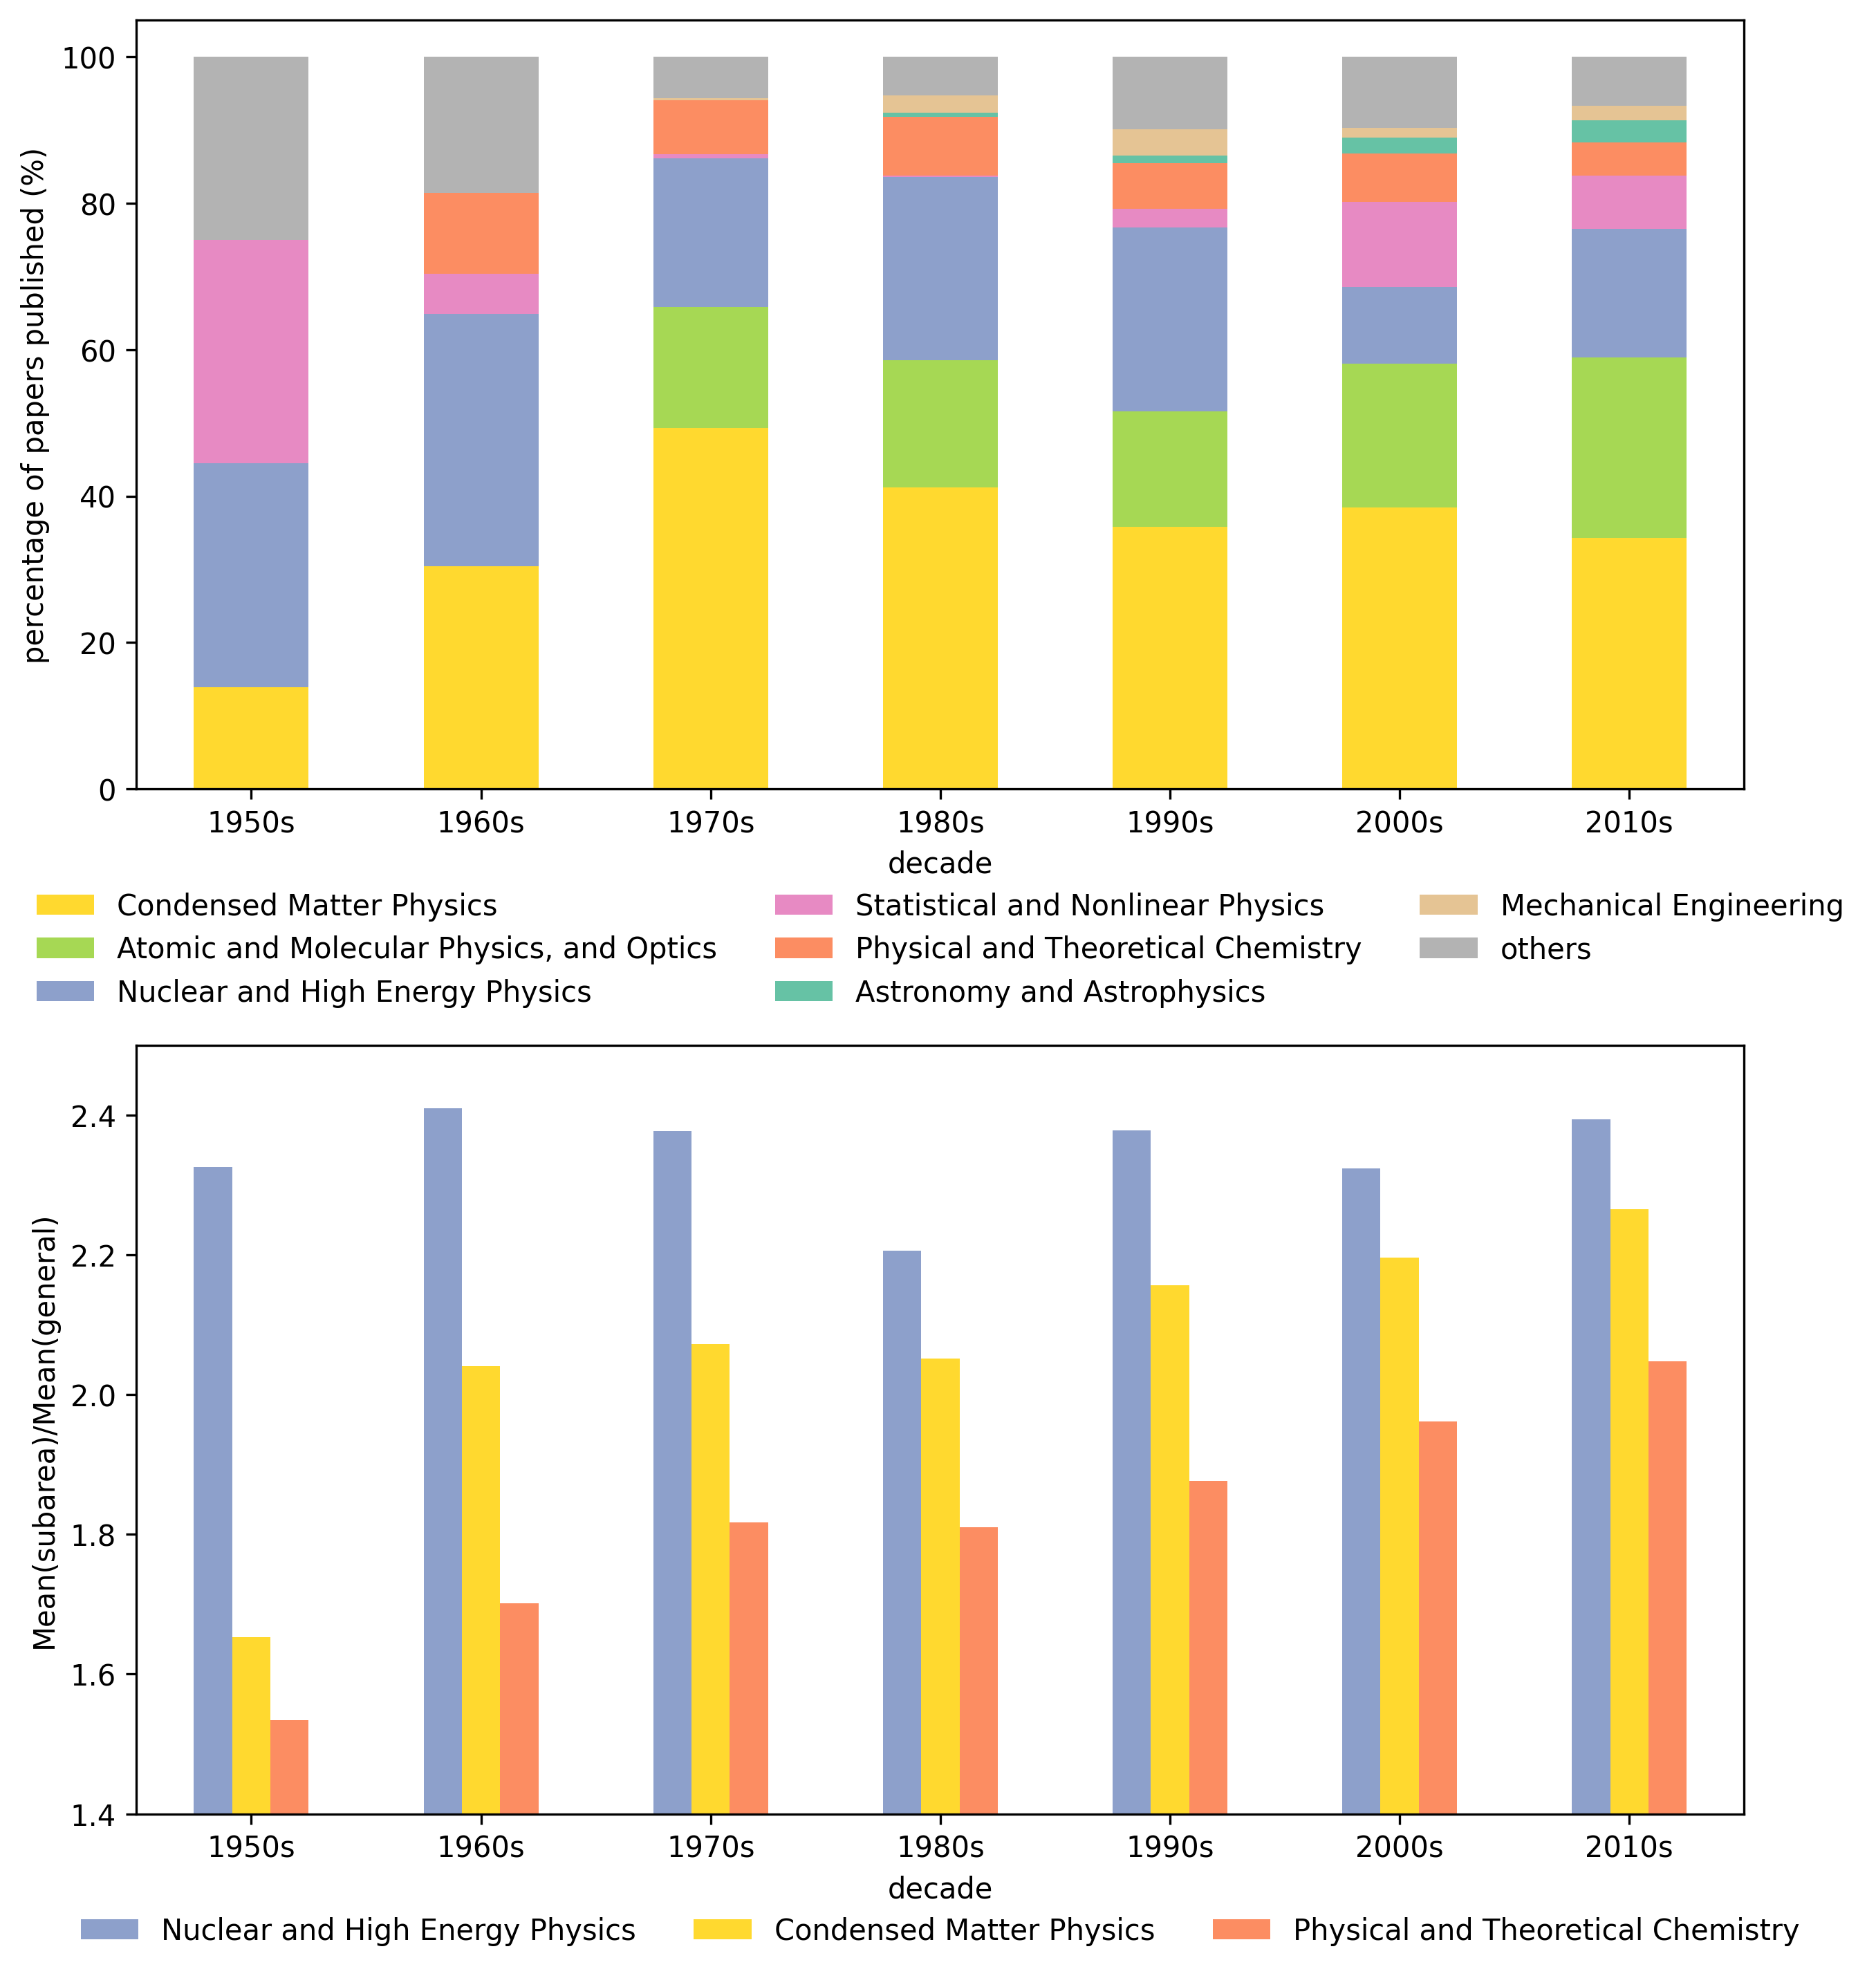

In [285]:
color_dict = {'Condensed Matter Physics': '#ffd92f',
              'Atomic and Molecular Physics, and Optics': '#a6d854',
              'Nuclear and High Energy Physics': '#8da0cb',	
              'Statistical and Nonlinear Physics':  '#e78ac3',
              'Physical and Theoretical Chemistry': '#fc8d62',	
              'Astronomy and Astrophysics': '#66c2a5',	
              'Mechanical Engineering': '#e5c494',
              'others': '#b3b3b3'
              }

fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Nuclear and High Energy Physics',
               'Condensed Matter Physics', 
               'Physical and Theoretical Chemistry']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.4, 2.5)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [286]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/PRL.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')